In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, 
    f1_score, precision_score, recall_score, 
    accuracy_score, confusion_matrix
)
import seaborn as sns
from pathlib import Path

import netCDF4
import numpy as np
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta
from tqdm import tqdm
from shapely.geometry import Point

from scipy.stats import skew, kurtosis, entropy

from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler


import os

from pycaret.classification import setup, load_model, load_experiment, compare_models, tune_model, finalize_model, save_model, plot_model, evaluate_model, dashboard, save_experiment, blend_models, get_config

import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split



In [35]:
ROOT_DIR = 'E:/data/RONGOWAI_L1_SDR_V1.0/'

In [36]:
class NetCDFPreprocessor:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.netcdf_file_list = os.listdir(root_dir)

    @staticmethod
    def check_integrity(f):
        """Check integrity of the netCDF file"""
        if not isinstance(f, netCDF4.Dataset):
            raise ValueError("Input must be a netCDF4.Dataset object")
        if 'raw_counts' not in f.variables:
            raise KeyError("The netCDF file does not contain 'raw_counts' variable")
        if 'sp_alt' not in f.variables or 'sp_inc_angle' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_alt' or 'sp_inc_angle' variables")
        if 'sp_rx_gain_copol' not in f.variables or 'sp_rx_gain_xpol' not in f.variables or 'ddm_snr' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_rx_gain_copol', 'sp_rx_gain_xpol' or 'ddm_snr' variables")
        if 'sp_lat' not in f.variables or 'sp_lon' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_lat' or 'sp_lon' variables")
        if 'sp_surface_type' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_surface_type' variable")
        if 'ac_alt' not in f.variables:
            raise KeyError("The netCDF file does not contain 'ac_alt' variable")
        if f.variables['raw_counts'].ndim != 4:
            raise ValueError("The 'raw_counts' variable must have 4 dimensions")
        
    def preprocess(self, f):
        """ Preprocess the netCDF file and return fit data and labels """
        # Check integrity of the netCDF file
        self.check_integrity(f)
        
        # Carica i dati una volta sola, evitando np.array() non necessario
        raw_counts = f.variables['raw_counts'][:]
        
        # Ottimizzazione 1: Usa broadcasting invece di repeat
        ac_alt = f.variables['ac_alt'][:]
        sp_alt = f.variables['sp_alt'][:]
        sp_inc_angle = f.variables['sp_inc_angle'][:]
        
        # Broadcasting più efficiente (evita repeat)
        distance_2d = (ac_alt[:, np.newaxis] - sp_alt) / np.cos(np.deg2rad(sp_inc_angle))
        
        # Carica tutte le variabili necessarie
        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        
        
        keep_mask = (
            (copol >= 5) & 
            (xpol >= 5) & 
            (snr > 0) & 
            (distance_2d >= 2000) & 
            (distance_2d <= 10000) &
            ~np.isnan(copol) & 
            ~np.isnan(xpol) & 
            ~np.isnan(snr) & 
            ~np.isnan(distance_2d)
        )
        
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)
        i_indices, j_indices = np.where(keep_mask)
        output_array[i_indices, j_indices] = raw_counts[i_indices, j_indices]
        
        n_time, n_samples = raw_counts.shape[:2]
        raw_counts_reshaped = output_array.reshape(n_time * n_samples, *raw_counts.shape[2:])
        
        valid_mask = ~np.any(np.isnan(raw_counts_reshaped), axis=(1, 2)) & (np.sum(raw_counts_reshaped, axis=(1, 2)) > 0)
        
        fit_data = raw_counts_reshaped[valid_mask].reshape(valid_mask.sum(), -1)
        
        surface_types = np.nan_to_num(f.variables["sp_surface_type"][:], nan=0).ravel()
        label_data = np.isin(surface_types, np.arange(1, 8)).astype(np.int32)
        label_data = label_data[valid_mask]
        
        assert fit_data.shape[0] == len(label_data), \
            f"Shape mismatch: fit_data {fit_data.shape[0]}, label_data {len(label_data)}"
        
        return fit_data, label_data
    
    def preprocess_w_lat_lons(self, f):
        """ Version with latitude and longitude extraction """

        self.check_integrity(f)
        raw_counts = np.array(f.variables['raw_counts'])
                
        # Calcolo distanza tra il punto speculare e l'aereo
        ac_alt_2d = np.repeat(np.array(f.variables['ac_alt'])[:, np.newaxis], 20, axis=1)
        distance_2d = (ac_alt_2d - f.variables['sp_alt'][:]) / np.cos(np.deg2rad(f.variables['sp_inc_angle'][:]))

        # Seleziono gli indici dove sp_rx_gain_copol > 5, sp_rx_gain_xpol > 5 e ddm_snr > 0 e distanza tra punto speculare e antenna > 2000 e < 10000

        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        dist = distance_2d[:]
        specular_point_lat = f.variables['sp_lat'][:]
        specular_point_lon = f.variables['sp_lon'][:]

        # Filtraggio dei dati
        keep_mask = (copol >= 5) & (xpol >= 5) & (snr > 0) & ((dist >= 2000) & (dist <= 10000)) & (~np.isnan(copol.data) & ~np.isnan(xpol.data) & ~np.isnan(snr.data) & ~np.isnan(dist.data) & ~np.isnan(specular_point_lat.data) & ~np.isnan(specular_point_lon.data))
        to_keep_indices = np.argwhere(keep_mask)
        
        filtered_raw_counts = [raw_counts[i, j] for i, j in to_keep_indices]
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)

        specular_point_lats = specular_point_lat[to_keep_indices[:, 0]]
        specular_point_lons = specular_point_lon[to_keep_indices[:, 0]]
        
        for idx, (i, j) in enumerate(to_keep_indices):
            output_array[i, j] = filtered_raw_counts[idx]
                
            raw_counts_filtered = output_array.copy()

        raw_counts_filtered = output_array.copy()
        del output_array

        ddm_data_dict = {
            'Raw_Counts': raw_counts_filtered.reshape(raw_counts_filtered.shape[0]*raw_counts_filtered.shape[1], raw_counts_filtered.shape[2], raw_counts_filtered.shape[3]),
        }

        keep_indices = np.where(
            np.all(~np.isnan(ddm_data_dict['Raw_Counts']), axis=(1, 2)) & (np.sum(ddm_data_dict['Raw_Counts'], axis=(1, 2)) > 0)
        )[0]
        fit_data = np.array([ddm_data_dict['Raw_Counts'][f].ravel() for f in keep_indices])

        specular_point_lats = specular_point_lat.ravel()[keep_indices]
        specular_point_lons = specular_point_lon.ravel()[keep_indices]
        
        surface_types = f.variables["sp_surface_type"][:]
        surface_types = np.nan_to_num(surface_types, nan=0)
        surface_types_unravelled = surface_types.ravel()
        label_data = [1 if surface_type in np.arange(1, 8) else 0 for surface_type in surface_types_unravelled]
        label_data = [label_data[lab] for lab in range(len(label_data)) if lab in keep_indices]

        assert np.array(fit_data).shape[0] == len(label_data) == np.array(specular_point_lats).shape[0] == np.array(specular_point_lons).shape[0], \
            f"Shape mismatch: fit_data {np.array(fit_data).shape[0]}, label_data {len(label_data)}, lats {np.array(specular_point_lats).shape[0]}, lons {np.array(specular_point_lons).shape[0]}"
        

        return fit_data, label_data, specular_point_lats, specular_point_lons


    def process_all_files(self, chunk_size = int, sample_fraction = float, remove_chunks= bool):
        
        full_data = []
        full_labels = []
        counter = 0
        # Prendi 500 file random dalla lista dei file netCDF
        if len(self.netcdf_file_list) > 500:
            np.random.seed(42)
            random_netcdf_selected_files = np.random.choice(self.netcdf_file_list, 500, replace=False)
            print('Selezionati 500 file netCDF casuali dalla lista')
        else:
            random_netcdf_selected_files = self.netcdf_file_list

        for file_name in tqdm(random_netcdf_selected_files, desc="Processing files"):
            if not file_name.endswith('.nc'):
                continue
            try:
                f = netCDF4.Dataset(f'{self.root_dir}{file_name}')
                data, labels = self.preprocess(f)
                assert (len(data) == len(labels)), f"Data and labels length mismatch in file {file_name}: {len(data)} != {len(labels)}"
                full_data.append(data)
                full_labels.append(labels)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                continue
            counter += 1
            if counter == 500:
                break  # Limita il numero di file processati per test
                
        # Trova gli indici degli elementi di full_data con seconda dimensione uguale a 200
        valid_indices = [i for i, arr in enumerate(full_data) if arr.ndim == 2 if arr.shape[1] == 200]

        # Applica la selezione a full_data e full_labels
        full_data_clean = [full_data[i] for i in valid_indices]
        full_labels_clean = [full_labels[i] for i in valid_indices]
        
        # Chunking 
        os.makedirs('test_data/binary_classification', exist_ok=True)

        chunk_size = chunk_size # dimensione del chunk in numero di campioni
        sample_fraction = sample_fraction # frazione di dati da campionare per ogni chunk

        full_data_sampled = []
        full_labels_sampled = []

        num_chunks = int(np.ceil(len(full_data_clean) / chunk_size))
        print(f"Total number of chunks: {num_chunks}")
        for idx in range(num_chunks):
            start = idx * chunk_size
            end = min((idx + 1) * chunk_size, len(full_data_clean))
            chunk_data = np.vstack(full_data_clean[start:end])
            chunk_labels = np.hstack(full_labels_clean[start:end])
            
            print(f"Chunk {idx + 1}/{num_chunks} processed with shape {chunk_data.shape} and labels shape {chunk_labels.shape}")

            # Salva ogni chunk come file parquet separato
            fit_data_df = pd.DataFrame(chunk_data)
            labels_df = pd.DataFrame(chunk_labels, columns=['label'])

            table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
            table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)

            pq.write_table(
                table_fit,
                f'test_data/binary_classification/fit_data_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            pq.write_table(
                table_labels,
                f'test_data/binary_classification/labels_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            
        # Imposta la frazione di dati da campionare per ogni chunk (es: 0.2 per il 20%)
        
            _, X_sampled, _, y_sampled = train_test_split(
                chunk_data, chunk_labels, 
                test_size=sample_fraction, 
                stratify=chunk_labels, 
                random_state=42
            )

            
            full_data_sampled.append(X_sampled)
            full_labels_sampled.append(y_sampled)

        del full_data, full_labels

        full_data_sampled_stratified = np.vstack(full_data_sampled)
        full_labels_sampled_stratified = np.hstack(full_labels_sampled)

        del full_data_sampled, full_labels_sampled
        print(f"Shape of sampled data after chunking and sampling: {np.array(full_data_sampled_stratified).shape}")
        print(f"Shape of sampled labels after chunking and sampling: {np.array(full_labels_sampled_stratified).shape}")
        
        # Crea la cartella test_data se non esiste
        os.makedirs('test_data/binary_classification', exist_ok=True)

        # Salva fit_data in formato parquet 
        fit_data_df = pd.DataFrame(full_data_sampled_stratified)
        table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
        pq.write_table(
            table_fit,
            'test_data/binary_classification/fit_data_binary_test.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )

        # Salva labels in formato parquet 
        labels_df = pd.DataFrame(full_labels_sampled_stratified, columns=['label'])
        table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)
        pq.write_table(
            table_labels,
            'test_data/binary_classification/labels_binary_test.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )
        del fit_data_df, labels_df, table_fit, table_labels
        
        print("Data and labels saved in test_data/binary_classification directory.")
        # Remove all chunk parquet files if flag is set
        if remove_chunks:
            try:
                chunk_dir = 'test_data/binary_classification'
                for fname in os.listdir(chunk_dir):
                    if fname.startswith('fit_data_chunk_') or fname.startswith('labels_chunk_'):
                        os.remove(os.path.join(chunk_dir, fname))
                print("All chunk files removed.")
            except Exception as e:
                print(f"Error removing chunk files: {e}")

        return full_data_sampled_stratified, full_labels_sampled_stratified

In [37]:
class DDMFeatureExtractor:
    def __init__(self):
        pass
    def gini(self, array):
            """Calcola il coefficiente di Gini (disuguaglianza)"""
            array = np.sort(array)
            index = np.arange(1, array.shape[0] + 1)
            return (np.sum((2 * index - array.shape[0] - 1) * array)) / (array.shape[0] * np.sum(array))    
    def extract_ddm_features(self, fit_data: np.ndarray) -> pd.DataFrame:

        """
        Estrae features dettagliate da raw_counts DDM (shape: n_samples x 200)
        """
        features = []

        for row in tqdm(fit_data, desc="Extracting DDM features"):
            f = {}
            x = np.array(row, dtype=np.float64) + 1e-10  # evita log(0)

            # 1. Statistiche base
            f['mean'] = np.mean(x)
            f['std'] = np.std(x)
            f['min'] = np.min(x)
            f['max'] = np.max(x)
            f['median'] = np.median(x)
            f['range'] = np.max(x) - np.min(x)
            f['skew'] = skew(x)
            f['kurtosis'] = kurtosis(x)
            f['entropy'] = entropy(x)
            f['gini'] = self.gini(x)

            # 2. Posizionali
            f['peak_index'] = np.argmax(x)
            f['peak_value'] = np.max(x)
            f['center_of_mass'] = np.sum(np.arange(len(x)) * x) / np.sum(x)
            f['inertia'] = np.sum(((np.arange(len(x)) - f['center_of_mass'])**2) * x)

            # 3. Segmentazione
            thirds = np.array_split(x, 3)
            for i, part in enumerate(thirds):
                f[f'sum_third_{i+1}'] = np.sum(part)
                f[f'mean_third_{i+1}'] = np.mean(part)
                f[f'max_third_{i+1}'] = np.max(part)
            
            windows = np.array_split(x, 5)
            for i, w in enumerate(windows):
                f[f'mean_w{i+1}'] = np.mean(w)
                f[f'std_w{i+1}'] = np.std(w)
                f[f'max_w{i+1}'] = np.max(w)

            # 4. Derivate e cambiamenti
            dx = np.diff(x)
            f['mean_diff'] = np.mean(dx)
            f['std_diff'] = np.std(dx)
            f['max_diff'] = np.max(dx)
            f['min_diff'] = np.min(dx)
            f['n_positive_diff'] = np.sum(dx > 0)
            f['n_negative_diff'] = np.sum(dx < 0)
            f['n_zero_diff'] = np.sum(dx == 0)

            # 5. Autocorrelazioni (lag 1-3)
            for lag in range(1, 4):
                ac = np.corrcoef(x[:-lag], x[lag:])[0, 1] if len(x) > lag else np.nan
                f[f'autocorr_lag{lag}'] = ac

            # 6. FFT (spettro frequenze)
            spectrum = np.abs(fft(x))
            half_spectrum = spectrum[:len(spectrum)//2]  # simmetrico
            f['fft_peak_freq'] = np.argmax(half_spectrum)
            f['fft_max'] = np.max(half_spectrum)
            f['fft_median'] = np.median(half_spectrum)
            f['fft_mean'] = np.mean(half_spectrum)

            
            #Aggiungi le statistiche dei quadranti e del centro
            ddm = row.reshape(10, 20)  # 10x20

            # Quadranti
            q1 = ddm[:5, :10].ravel()
            q2 = ddm[:5, 10:].ravel()
            q3 = ddm[5:, :10].ravel()
            q4 = ddm[5:, 10:].ravel()
            # Quadrante centrale (4x8 centrale)
            center = ddm[3:7, 6:14].ravel()
            
            # Statistiche dei quadranti 
            f['q1_mean'] = np.mean(q1)
            f['q2_mean'] = np.mean(q2)      
            f['q3_mean'] = np.mean(q3)
            f['q4_mean'] = np.mean(q4)
            f['center_mean'] = np.mean(center)
            f['q1_std'] = np.std(q1)
            f['q2_std'] = np.std(q2)
            f['q3_std'] = np.std(q3)
            f['q4_std'] = np.std(q4)
            f['center_std'] = np.std(center)
            f['q1_min'] = np.min(q1)
            f['q2_min'] = np.min(q2)
            f['q3_min'] = np.min(q3)
            f['q4_min'] = np.min(q4)
            f['center_min'] = np.min(center)
            f['q1_max'] = np.max(q1)
            f['q2_max'] = np.max(q2)
            f['q3_max'] = np.max(q3)
            f['q4_max'] = np.max(q4)
            f['center_max'] = np.max(center)
            f['q1_median'] = np.median(q1)
            f['q2_median'] = np.median(q2)
            f['q3_median'] = np.median(q3)
            f['q4_median'] = np.median(q4)
            f['center_median'] = np.median(center)
            f['q1_range'] = np.max(q1) - np.min(q1)
            f['q2_range'] = np.max(q2) - np.min(q2)
            f['q3_range'] = np.max(q3) - np.min(q3)
            f['q4_range'] = np.max(q4) - np.min(q4)
            f['center_range'] = np.max(center) - np.min(center)
            f['q1_skew'] = skew(q1)
            f['q2_skew'] = skew(q2)
            f['q3_skew'] = skew(q3)
            f['q4_skew'] = skew(q4)
            f['center_skew'] = skew(center)
            f['q1_kurtosis'] = kurtosis(q1)
            f['q2_kurtosis'] = kurtosis(q2)
            f['q3_kurtosis'] = kurtosis(q3)
            f['q4_kurtosis'] = kurtosis(q4)
            f['center_kurtosis'] = kurtosis(center)
            f['q1_entropy'] = entropy(q1 + 1e-10)
            f['q2_entropy'] = entropy(q2 + 1e-10)
            f['q3_entropy'] = entropy(q3 + 1e-10)
            f['q4_entropy'] = entropy(q4 + 1e-10)
            f['center_entropy'] = entropy(center + 1e-10)
            f['q1_gini'] = self.gini(q1)
            f['q2_gini'] = self.gini(q2)
            f['q3_gini'] = self.gini(q3)
            f['q4_gini'] = self.gini(q4)
            f['center_gini'] = self.gini(center)

            # Statistiche di confronto tra quadranti e centro
            
            # Differenze tra media dei quadranti e centro
            f['q1_center_mean_diff'] = f['q1_mean'] - f['center_mean']
            f['q2_center_mean_diff'] = f['q2_mean'] - f['center_mean']
            f['q3_center_mean_diff'] = f['q3_mean'] - f['center_mean']
            f['q4_center_mean_diff'] = f['q4_mean'] - f['center_mean']

            # Differenze tra std dei quadranti e centro
            f['q1_center_std_diff'] = f['q1_std'] - f['center_std']
            f['q2_center_std_diff'] = f['q2_std'] - f['center_std']
            f['q3_center_std_diff'] = f['q3_std'] - f['center_std']
            f['q4_center_std_diff'] = f['q4_std'] - f['center_std']

            # Differenze tra max dei quadranti e centro
            f['q1_center_max_diff'] = f['q1_max'] - f['center_max']
            f['q2_center_max_diff'] = f['q2_max'] - f['center_max']
            f['q3_center_max_diff'] = f['q3_max'] - f['center_max']
            f['q4_center_max_diff'] = f['q4_max'] - f['center_max']

            # Differenze tra min dei quadranti e centro
            f['q1_center_min_diff'] = f['q1_min'] - f['center_min']
            f['q2_center_min_diff'] = f['q2_min'] - f['center_min']
            f['q3_center_min_diff'] = f['q3_min'] - f['center_min']
            f['q4_center_min_diff'] = f['q4_min'] - f['center_min']

            # Differenze tra entropia dei quadranti e centro
            f['q1_center_entropy_diff'] = f['q1_entropy'] - f['center_entropy']
            f['q2_center_entropy_diff'] = f['q2_entropy'] - f['center_entropy']
            f['q3_center_entropy_diff'] = f['q3_entropy'] - f['center_entropy']
            f['q4_center_entropy_diff'] = f['q4_entropy'] - f['center_entropy']

            # Differenze tra gini dei quadranti e centro
            f['q1_center_gini_diff'] = f['q1_gini'] - f['center_gini']
            f['q2_center_gini_diff'] = f['q2_gini'] - f['center_gini']
            f['q3_center_gini_diff'] = f['q3_gini'] - f['center_gini']
            f['q4_center_gini_diff'] = f['q4_gini'] - f['center_gini']

            # Differenze tra skewness dei quadranti e centro
            f['q1_center_skew_diff'] = f['q1_skew'] - f['center_skew']
            f['q2_center_skew_diff'] = f['q2_skew'] - f['center_skew']
            f['q3_center_skew_diff'] = f['q3_skew'] - f['center_skew']
            f['q4_center_skew_diff'] = f['q4_skew'] - f['center_skew']

            # Differenze tra kurtosis dei quadranti e centro
            f['q1_center_kurtosis_diff'] = f['q1_kurtosis'] - f['center_kurtosis']
            f['q2_center_kurtosis_diff'] = f['q2_kurtosis'] - f['center_kurtosis']
            f['q3_center_kurtosis_diff'] = f['q3_kurtosis'] - f['center_kurtosis']
            f['q4_center_kurtosis_diff'] = f['q4_kurtosis'] - f['center_kurtosis']

            features.append(f)
            
        return features

In [38]:
read_from_backup = False
if read_from_backup:
    
    # Leggi i file parquet con polars
    fit_data_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/fit_data_binary_test.parquet')
    labels_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/labels_binary_test.parquet')

    # Trasforma in numpy array
    fit_data = fit_data_pl.to_numpy()
    labels = labels_pl['label'].to_numpy()
    del fit_data_pl, labels_pl
else:
    preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR)
    fit_data, labels = preprocessor.process_all_files(chunk_size=250, sample_fraction=0.2,remove_chunks=True)

Selezionati 500 file netCDF casuali dalla lista


Processing files:   8%|▊         | 41/500 [00:04<00:57,  7.99it/s]

Error processing file 20250212-195305_NZAA-NZWR_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  33%|███▎      | 164/500 [00:19<00:33,  9.89it/s]

Error processing file 20240927-100501_NZHK-NZCH_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  62%|██████▏   | 311/500 [00:38<00:23,  7.93it/s]

Error processing file 20241218-201112_NZWN-NZTG_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files: 100%|██████████| 500/500 [01:02<00:00,  8.04it/s]


Total number of chunks: 2
Chunk 1/2 processed with shape (1869943, 200) and labels shape (1869943,)
Chunk 2/2 processed with shape (1875504, 200) and labels shape (1875504,)
Shape of sampled data after chunking and sampling: (749090, 200)
Shape of sampled labels after chunking and sampling: (749090,)
Data and labels saved in test_data/binary_classification directory.
All chunk files removed.


In [39]:
num_samples = 1000000
indices = np.random.choice(fit_data.shape[0], size=num_samples, replace=True)
fit_data = fit_data[indices]
labels = labels[indices]

In [40]:
preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR)
features_extractor = DDMFeatureExtractor()

In [41]:
from joblib import Parallel, delayed

def extract_ddm_features_row(row):
    return features_extractor.extract_ddm_features(np.array([row]))

combined_features = Parallel(n_jobs=12, backend="loky")(delayed(extract_ddm_features_row)(row) for row in tqdm(fit_data, desc="Estrazione features"))

Estrazione features:   0%|          | 0/1000000 [00:00<?, ?it/s]

Estrazione features: 100%|██████████| 1000000/1000000 [06:39<00:00, 2503.50it/s]


In [42]:
flat_features = [row[0] if isinstance(row, list) and len(row) > 0 else row for row in combined_features]
FEATURES = list(flat_features[0].keys())

In [43]:
combined_features = np.array([[row[key] for key in FEATURES] for row in flat_features])
combined_features.shape

# Controlla infiniti o valori troppo grandi per float64
mask_finite = np.isfinite(combined_features).all(axis=1) & (np.abs(combined_features) < np.finfo(np.float64).max).all(axis=1)
fit_data_with_features_clean = combined_features[mask_finite]
labels_clean = labels[mask_finite]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, 
    f1_score, precision_score, recall_score, 
    accuracy_score, confusion_matrix, fbeta_score,
    balanced_accuracy_score, matthews_corrcoef
)
import seaborn as sns
from pathlib import Path


class ThresholdOptimizer:
    """Classe per ottimizzare la soglia di classificazione di un modello CatBoost"""
    
    def __init__(self, model_path):
        """
        Inizializza l'ottimizzatore caricando il modello
        
        Args:
            model_path (str): Percorso del modello CatBoost salvato
        """
        self.model_path = Path(model_path)
        self.model = self._load_model()
        self.results = {}
        
    def _load_model(self):
        """Carica il modello CatBoost dal percorso specificato"""
        try:
            model = CatBoostClassifier()
            model.load_model(str(self.model_path))
            print(f"Modello caricato con successo da: {self.model_path}")
            return model
        except Exception as e:
            print(f"Errore nel caricamento del modello: {e}")
            raise
    
    def predict_proba(self, X):
        """
        Genera le probabilità di predizione
        
        Args:
            X: Features di input (DataFrame o array)
            
        Returns:
            array: Probabilità per la classe positiva
        """
        proba = self.model.predict_proba(X)
        return proba[:, 1]  # Probabilità della classe positiva
    
    def evaluate_threshold(self, y_true, y_proba, threshold):
        """
        Valuta le performance per una soglia specifica
        
        Args:
            y_true: Etichette vere
            y_proba: Probabilità predette
            threshold: Soglia di classificazione
            
        Returns:
            dict: Metriche di valutazione
        """
        y_pred = (y_proba >= threshold).astype(int)
        
        # Calcola la matrice di confusione
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
        
        # Calcola metriche multiple
        metrics = {
            'threshold': threshold,
            'accuracy': accuracy_score(y_true, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'f0.5': fbeta_score(y_true, y_pred, beta=0.5, zero_division=0),
            'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'mcc': matthews_corrcoef(y_true, y_pred),
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'predictions': y_pred
        }
        
        # Aggiungi F-beta scores personalizzati
        for beta in [0.1, 0.3, 0.7, 1.5, 3, 5]:
            metrics[f'f{beta}'] = fbeta_score(y_true, y_pred, beta=beta, zero_division=0)
        
        return metrics
    
    def create_custom_metric(self, precision_weight=0.5, recall_weight=0.5, 
                           specificity_weight=0, cost_fp=1, cost_fn=1):
        """
        Crea una metrica personalizzata per l'ottimizzazione
        
        Args:
            precision_weight: Peso per la precision (default: 0.5)
            recall_weight: Peso per la recall (default: 0.5)
            specificity_weight: Peso per la specificity (default: 0)
            cost_fp: Costo relativo dei falsi positivi (default: 1)
            cost_fn: Costo relativo dei falsi negativi (default: 1)
            
        Returns:
            function: Funzione che calcola la metrica personalizzata
        """
        # Normalizza i pesi
        total_weight = precision_weight + recall_weight + specificity_weight
        if total_weight > 0:
            precision_weight /= total_weight
            recall_weight /= total_weight
            specificity_weight /= total_weight
        
        def custom_metric(metrics_dict):
            precision = metrics_dict['precision']
            recall = metrics_dict['recall']
            specificity = metrics_dict['specificity']
            fp = metrics_dict['fp']
            fn = metrics_dict['fn']
            
            # Metrica pesata
            weighted_score = (
                precision_weight * precision +
                recall_weight * recall +
                specificity_weight * specificity
            )
            
            # Penalità per costi
            total_samples = metrics_dict['tp'] + metrics_dict['tn'] + fp + fn
            if total_samples > 0:
                cost_penalty = (cost_fp * fp + cost_fn * fn) / total_samples
                final_score = weighted_score - cost_penalty
            else:
                final_score = weighted_score
            
            return final_score
        
        return custom_metric
    
    def optimize_threshold(self, X_val, y_val, metric='f1', thresholds=None,
                         beta=None, custom_metric=None, balance_params=None):
        """
        Trova la soglia ottimale basandosi su una metrica specifica
        
        Args:
            X_val: Features di validazione
            y_val: Etichette di validazione
            metric: Metrica da ottimizzare. Opzioni:
                    - 'f1', 'f0.5', 'f2', etc.: F-beta scores
                    - 'precision', 'recall', 'accuracy', 'balanced_accuracy'
                    - 'mcc': Matthews Correlation Coefficient
                    - 'custom': usa custom_metric
                    - 'balanced': usa balance_params per creare metrica bilanciata
            thresholds: Array di soglie da testare (default: 0.0 a 1.0 con step 0.01)
            beta: Valore beta per F-beta score (sovrascrive metric se specificato)
            custom_metric: Funzione personalizzata per il calcolo della metrica
            balance_params: Dict con parametri per bilanciamento:
                          {'precision_weight': float, 'recall_weight': float,
                           'specificity_weight': float, 'cost_fp': float, 'cost_fn': float}
            
        Returns:
            dict: Risultati dell'ottimizzazione
        """
        # Calcola le probabilità
        y_proba = self.predict_proba(X_val)
        
        # Definisci le soglie da testare
        if thresholds is None:
            thresholds = np.arange(0.01, 1.0, 0.01)
        
        # Gestisci le metriche personalizzate
        if metric == 'balanced' and balance_params:
            custom_metric = self.create_custom_metric(**balance_params)
            metric = 'custom'
        
        if beta is not None:
            metric = f'f{beta}'
        
        # Valuta ogni soglia
        results = []
        for threshold in thresholds:
            eval_results = self.evaluate_threshold(y_val, y_proba, threshold)
            
            # Aggiungi metrica custom se necessario
            if metric == 'custom' and custom_metric:
                eval_results['custom'] = custom_metric(eval_results)
            
            results.append(eval_results)
        
        # Converti in DataFrame per facilità di manipolazione
        results_df = pd.DataFrame(results)
        
        # Trova la soglia ottimale
        if metric in results_df.columns:
            optimal_idx = results_df[metric].idxmax()
        else:
            raise ValueError(f"Metrica '{metric}' non riconosciuta. "
                           f"Opzioni disponibili: {list(results_df.columns)}")
        
        optimal_threshold = results_df.loc[optimal_idx, 'threshold']
        optimal_metrics = results_df.loc[optimal_idx].to_dict()
        
        # Salva i risultati
        self.results = {
            'optimization_metric': metric,
            'all_results': results_df,
            'optimal_threshold': optimal_threshold,
            'optimal_metrics': optimal_metrics,
            'y_proba': y_proba,
            'y_true': y_val,
            'balance_params': balance_params if metric == 'balanced' else None
        }
        
        print(f"\nOttimizzazione completata per metrica: {metric}")
        print(f"Soglia ottimale: {optimal_threshold:.3f}")
        print("\nMetriche alla soglia ottimale:")
        for k, v in optimal_metrics.items():
            if k not in ['threshold', 'predictions'] and isinstance(v, (int, float)):
                print(f"  {k}: {v:.3f}")
        
        return self.results
    
    def plot_threshold_analysis(self, figsize=(15, 10)):
        """
        Visualizza l'analisi delle soglie con grafici multipli
        """
        if not self.results:
            raise ValueError("Esegui prima optimize_threshold()")
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Analisi Ottimizzazione Soglia', fontsize=16)
        
        results_df = self.results['all_results']
        optimal_threshold = self.results['optimal_threshold']
        
        # 1. Metriche vs Soglia
        ax1 = axes[0, 0]
        ax1.plot(results_df['threshold'], results_df['precision'], label='Precision', color='blue')
        ax1.plot(results_df['threshold'], results_df['recall'], label='Recall', color='green')
        ax1.plot(results_df['threshold'], results_df['f1'], label='F1-Score', color='red')
        ax1.axvline(optimal_threshold, color='black', linestyle='--', alpha=0.7, 
                   label=f'Soglia Ottimale: {optimal_threshold:.3f}')
        ax1.set_xlabel('Soglia')
        ax1.set_ylabel('Score')
        ax1.set_title('Metriche vs Soglia')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Curva ROC
        ax2 = axes[0, 1]
        fpr, tpr, _ = roc_curve(self.results['y_true'], self.results['y_proba'])
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Curva ROC')
        ax2.legend(loc="lower right")
        ax2.grid(True, alpha=0.3)
        
        # 3. Curva Precision-Recall
        ax3 = axes[1, 0]
        precision, recall, _ = precision_recall_curve(self.results['y_true'], 
                                                      self.results['y_proba'])
        ax3.plot(recall, precision, color='darkgreen', lw=2)
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.set_title('Curva Precision-Recall')
        ax3.grid(True, alpha=0.3)
        
        # 4. Distribuzione delle probabilità
        ax4 = axes[1, 1]
        y_proba_pos = self.results['y_proba'][self.results['y_true'] == 1]
        y_proba_neg = self.results['y_proba'][self.results['y_true'] == 0]
        
        ax4.hist(y_proba_neg, bins=50, alpha=0.5, label='Classe Negativa', color='blue')
        ax4.hist(y_proba_pos, bins=50, alpha=0.5, label='Classe Positiva', color='red')
        ax4.axvline(optimal_threshold, color='black', linestyle='--', 
                   label=f'Soglia Ottimale: {optimal_threshold:.3f}')
        ax4.set_xlabel('Probabilità Predetta')
        ax4.set_ylabel('Frequenza')
        ax4.set_title('Distribuzione delle Probabilità per Classe')
        ax4.legend()
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, threshold=0.55):
        """
        Visualizza la matrice di confusione per una soglia specifica
        
        Args:
            threshold: Soglia da utilizzare (default: soglia ottimale)
        """
        if not self.results:
            raise ValueError("Esegui prima optimize_threshold()")
        
        if threshold is None:
            threshold = self.results['optimal_threshold']
        
        y_pred = (self.results['y_proba'] >= threshold).astype(int)
        cm = confusion_matrix(self.results['y_true'], y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matrice di Confusione (Soglia: {threshold:.3f})')
        plt.ylabel('Vero')
        plt.xlabel('Predetto')
        plt.show()
    
    def plot_balance_analysis(self, beta_values=[0.1, 0.5, 1, 2, 5], figsize=(12, 8)):
        """
        Visualizza come diverse impostazioni di bilanciamento influenzano la soglia ottimale
        
        Args:
            beta_values: Lista di valori beta da testare per F-beta score
            figsize: Dimensione della figura
        """
        if not self.results:
            raise ValueError("Esegui prima optimize_threshold()")
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Analisi del Bilanciamento Precision-Recall', fontsize=16)
        
        results_df = self.results['all_results']
        
        # 1. F-beta scores vs Soglia per diversi beta
        ax1 = axes[0, 0]
        for beta in beta_values:
            col_name = f'f{beta}'
            if col_name in results_df.columns:
                ax1.plot(results_df['threshold'], results_df[col_name], 
                        label=f'F-{beta} score', linewidth=2)
        ax1.set_xlabel('Soglia')
        ax1.set_ylabel('F-beta Score')
        ax1.set_title('F-beta Scores per Diversi Valori di Beta')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Trade-off Precision-Recall
        ax2 = axes[0, 1]
        scatter = ax2.scatter(results_df['recall'], results_df['precision'], 
                            c=results_df['threshold'], cmap='viridis', s=20)
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Trade-off Precision-Recall')
        plt.colorbar(scatter, ax=ax2, label='Soglia')
        ax2.grid(True, alpha=0.3)
        
        # 3. Soglie ottimali per diversi beta
        ax3 = axes[1, 0]
        optimal_thresholds = []
        optimal_f_scores = []
        
        for beta in beta_values:
            col_name = f'f{beta}'
            if col_name in results_df.columns:
                optimal_idx = results_df[col_name].idxmax()
                optimal_thresholds.append(results_df.loc[optimal_idx, 'threshold'])
                optimal_f_scores.append(results_df.loc[optimal_idx, col_name])
        
        ax3.plot(beta_values[:len(optimal_thresholds)], optimal_thresholds, 
                'o-', color='darkblue', linewidth=2, markersize=8)
        ax3.set_xlabel('Beta (peso relativo recall vs precision)')
        ax3.set_ylabel('Soglia Ottimale')
        ax3.set_title('Soglia Ottimale vs Beta')
        ax3.grid(True, alpha=0.3)
        ax3.set_xscale('log')
        
        # 4. Metriche bilanciate
        ax4 = axes[1, 1]
        if 'mcc' in results_df.columns:
            ax4.plot(results_df['threshold'], results_df['mcc'], 
                    label='MCC', color='purple', linewidth=2)
        ax4.plot(results_df['threshold'], results_df['balanced_accuracy'], 
                label='Balanced Accuracy', color='orange', linewidth=2)
        ax4.plot(results_df['threshold'], results_df['f1'], 
                label='F1-Score', color='green', linewidth=2)
        ax4.set_xlabel('Soglia')
        ax4.set_ylabel('Score')
        ax4.set_title('Metriche Bilanciate')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compare_optimization_strategies(self, X_val, y_val, strategies, figsize=(14, 6)):
        """
        Confronta diverse strategie di ottimizzazione
        
        Args:
            X_val: Features di validazione
            y_val: Etichette di validazione
            strategies: Lista di dizionari con strategie di ottimizzazione
                       Es: [{'name': 'F1', 'metric': 'f1'},
                            {'name': 'High Precision', 'metric': 'f0.5'},
                            {'name': 'Custom', 'metric': 'balanced', 
                             'balance_params': {...}}]
            figsize: Dimensione della figura
        """
        results_comparison = []
        
        for strategy in strategies:
            name = strategy['name']
            metric = strategy.get('metric', 'f1')
            balance_params = strategy.get('balance_params', None)
            beta = strategy.get('beta', None)
            
            # Ottimizza per questa strategia
            self.optimize_threshold(X_val, y_val, metric=metric, 
                                  beta=beta, balance_params=balance_params)
            
            # Salva i risultati
            results_comparison.append({
                'strategy': name,
                'optimal_threshold': self.results['optimal_threshold'],
                'precision': self.results['optimal_metrics']['precision'],
                'recall': self.results['optimal_metrics']['recall'],
                'f1': self.results['optimal_metrics']['f1'],
                'specificity': self.results['optimal_metrics']['specificity'],
                'balanced_accuracy': self.results['optimal_metrics']['balanced_accuracy']
            })
        
        # Crea DataFrame per confronto
        comparison_df = pd.DataFrame(results_comparison)
        
        # Visualizza confronto
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # 1. Confronto soglie ottimali
        ax1 = axes[0]
        ax1.bar(comparison_df['strategy'], comparison_df['optimal_threshold'])
        ax1.set_xlabel('Strategia')
        ax1.set_ylabel('Soglia Ottimale')
        ax1.set_title('Soglie Ottimali per Strategia')
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Confronto metriche
        ax2 = axes[1]
        metrics_to_plot = ['precision', 'recall', 'f1', 'specificity']
        x = np.arange(len(comparison_df))
        width = 0.2
        
        for i, metric in enumerate(metrics_to_plot):
            ax2.bar(x + i*width, comparison_df[metric], width, label=metric)
        
        ax2.set_xlabel('Strategia')
        ax2.set_ylabel('Score')
        ax2.set_title('Confronto Metriche per Strategia')
        ax2.set_xticks(x + width * 1.5)
        ax2.set_xticklabels(comparison_df['strategy'], rotation=45)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        return comparison_df
 
    def save_optimization_config(self, filepath):
        """
        Salva la configurazione di ottimizzazione corrente
        
        Args:
            filepath: Percorso dove salvare la configurazione
        """
        if not self.results:
            raise ValueError("Nessuna ottimizzazione da salvare. Esegui prima optimize_threshold()")
        
        config = {
            'optimal_threshold': self.results['optimal_threshold'],
            'optimization_metric': self.results['optimization_metric'],
            'balance_params': self.results.get('balance_params', None),
            'optimal_metrics': {k: v for k, v in self.results['optimal_metrics'].items() 
                              if k != 'predictions'},
            'model_path': str(self.model_path)
        }
        
        import json
        with open(filepath, 'w') as f:
            json.dump(config, f, indent=4)
        
        print(f"Configurazione salvata in: {filepath}")
    
    def load_and_apply_threshold(self, config_filepath):
        """
        Carica una configurazione salvata e restituisce la soglia ottimale
        
        Args:
            config_filepath: Percorso del file di configurazione
            
        Returns:
            float: Soglia ottimale dalla configurazione
        """
        import json
        with open(config_filepath, 'r') as f:
            config = json.load(f)
        
        print(f"Configurazione caricata da: {config_filepath}")
        print(f"Soglia ottimale: {config['optimal_threshold']:.3f}")
        print(f"Metrica di ottimizzazione: {config['optimization_metric']}")
        
        return config['optimal_threshold']



Modello caricato con successo da: models\catboost_test120625_1946\catboost_trained_on_full_data_model_v1.cbm
Modello caricato con successo da: models\catboost_test120625_1946\catboost_trained_on_full_data_model_v1.cbm

Ottimizzazione completata per metrica: f2
Soglia ottimale: 0.350

Metriche alla soglia ottimale:
  accuracy: 0.799
  balanced_accuracy: 0.839
  precision: 0.600
  recall: 0.935
  specificity: 0.743
  f1: 0.731
  f0.5: 0.646
  f2: 0.841
  mcc: 0.619
  tp: 13659.000
  tn: 26292.000
  fp: 9101.000
  fn: 948.000
  f0.1: 0.602
  f0.3: 0.618
  f0.7: 0.680
  f1.5: 0.798
  f3: 0.886
  f5: 0.915


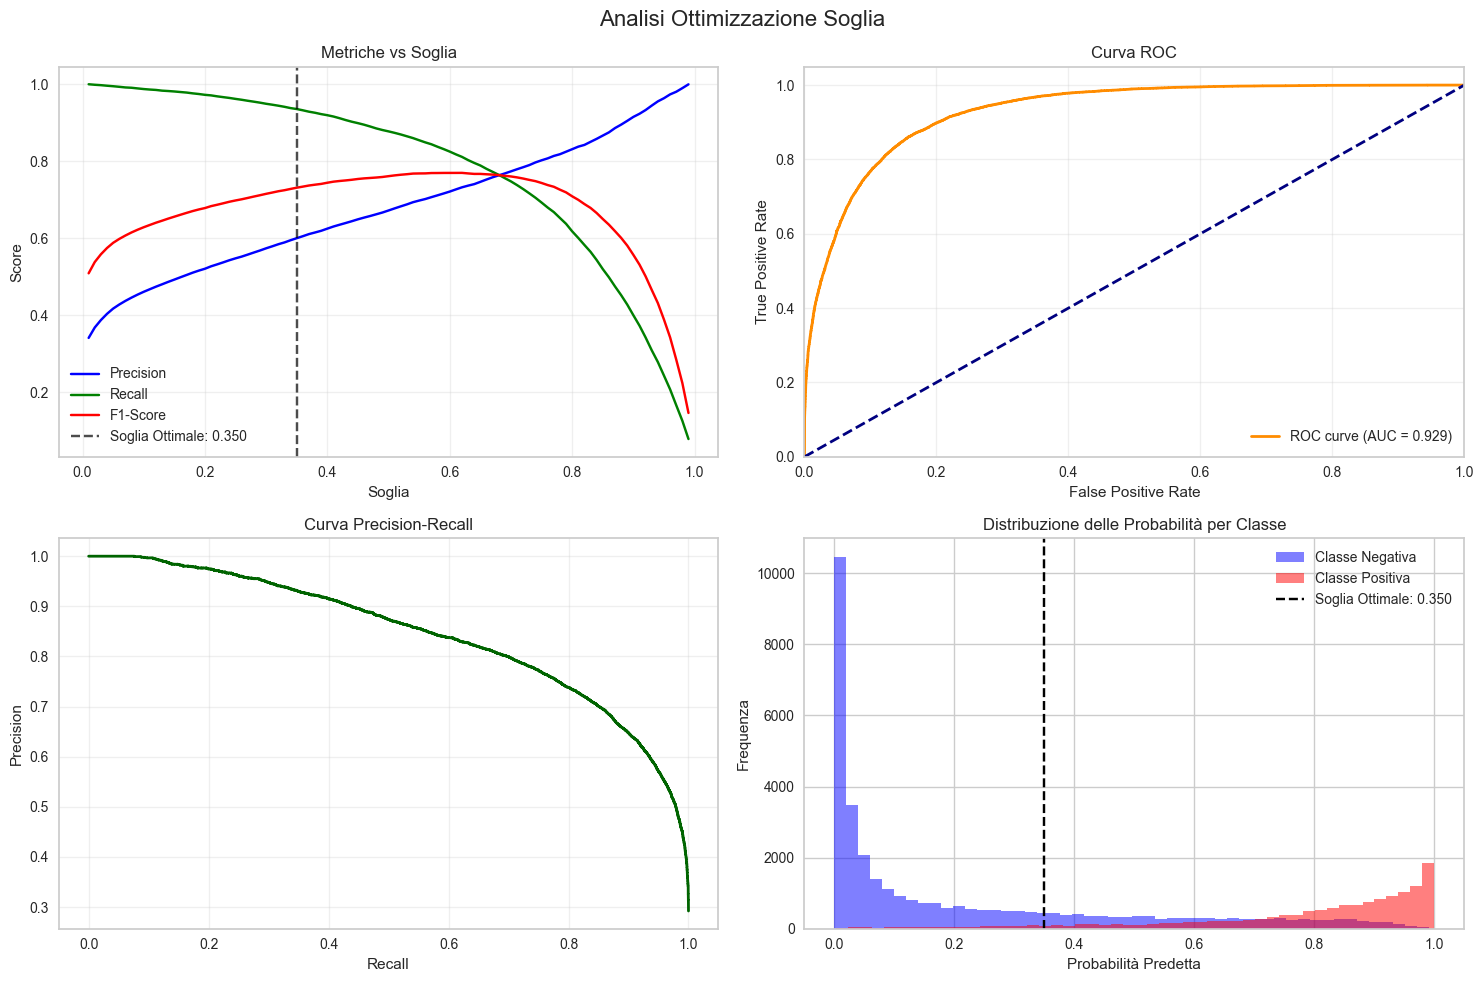

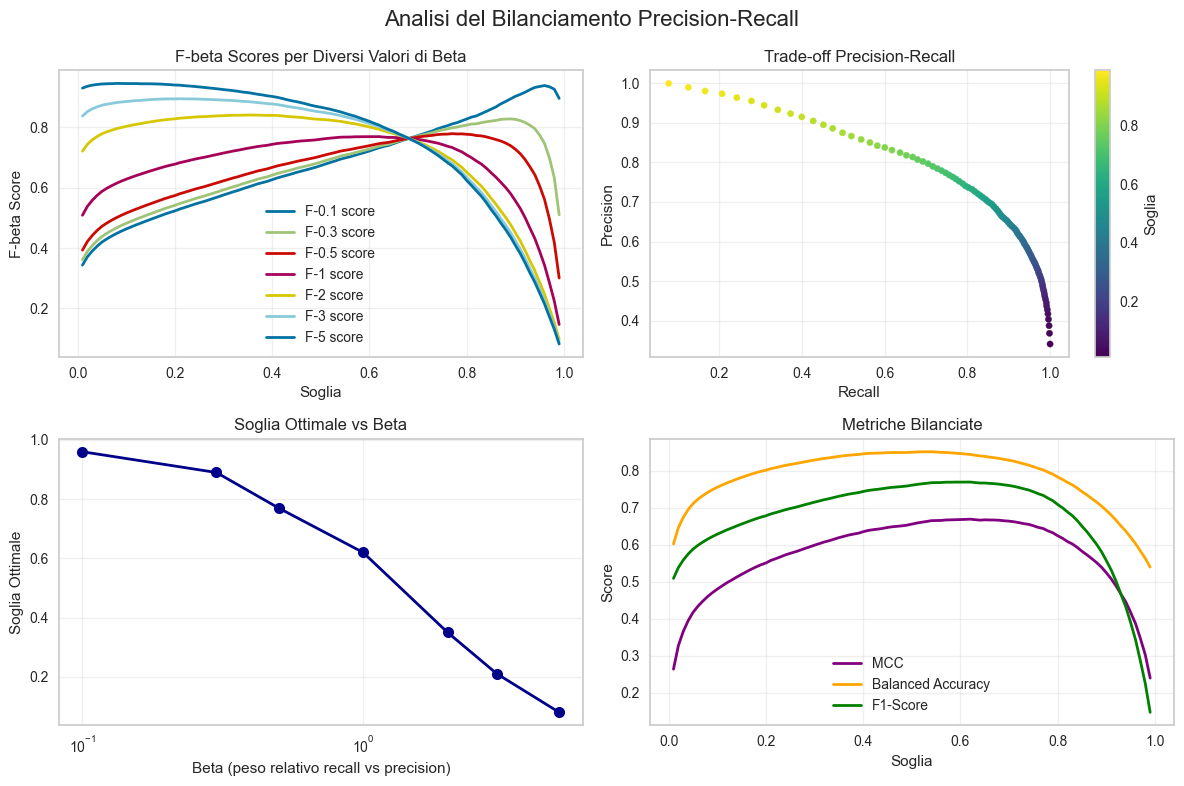

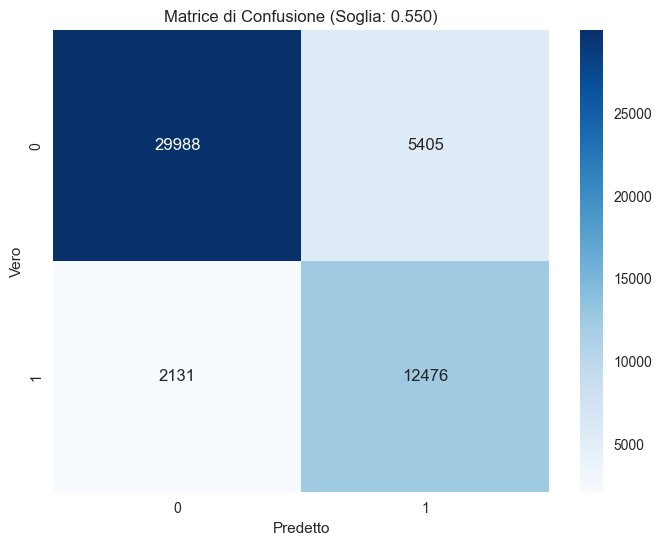


Ottimizzazione completata per metrica: f1
Soglia ottimale: 0.620

Metriche alla soglia ottimale:
  accuracy: 0.858
  balanced_accuracy: 0.844
  precision: 0.732
  recall: 0.811
  specificity: 0.878
  f1: 0.770
  f0.5: 0.747
  f2: 0.794
  mcc: 0.669
  tp: 11846.000
  tn: 31058.000
  fp: 4335.000
  fn: 2761.000
  f0.1: 0.733
  f0.3: 0.738
  f0.7: 0.756
  f1.5: 0.785
  f3: 0.802
  f5: 0.808

Ottimizzazione completata per metrica: f0.5
Soglia ottimale: 0.770

Metriche alla soglia ottimale:
  accuracy: 0.858
  balanced_accuracy: 0.802
  precision: 0.813
  recall: 0.668
  specificity: 0.937
  f1: 0.733
  f0.5: 0.779
  f2: 0.693
  mcc: 0.644
  tp: 9755.000
  tn: 33156.000
  fp: 2237.000
  fn: 4852.000
  f0.1: 0.812
  f0.3: 0.799
  f0.7: 0.759
  f1.5: 0.707
  f3: 0.680
  f5: 0.672

Ottimizzazione completata per metrica: f2
Soglia ottimale: 0.350

Metriche alla soglia ottimale:
  accuracy: 0.799
  balanced_accuracy: 0.839
  precision: 0.600
  recall: 0.935
  specificity: 0.743
  f1: 0.731
  f0

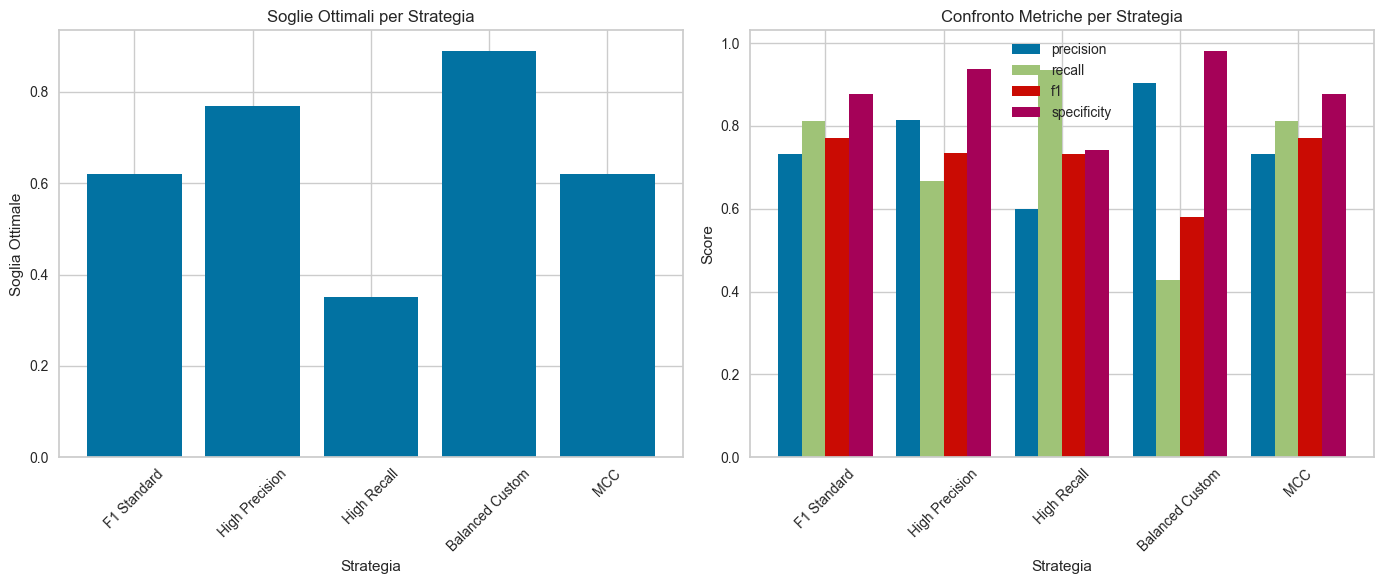


Confronto Strategie:
          strategy  optimal_threshold  precision    recall        f1  \
0      F1 Standard               0.62   0.732093  0.810981  0.769521   
1   High Precision               0.77   0.813459  0.667830  0.733486   
2      High Recall               0.35   0.600132  0.935100  0.731073   
3  Balanced Custom               0.89   0.904486  0.427877  0.580936   
4              MCC               0.62   0.732093  0.810981  0.769521   

   specificity  balanced_accuracy  
0     0.877518           0.844250  
1     0.936795           0.802313  
2     0.742859           0.838979  
3     0.981352           0.704615  
4     0.877518           0.844250  


In [48]:
from joblib import load

scaler_path = "./models/catboost_trained_on_full_data_model_v1_scaler.joblib"
scaler = load(scaler_path)

# Percorso del modello
model_path = r"./models/catboost_test120625_1946/catboost_trained_on_full_data_model_v1.cbm"

# Inizializza l'ottimizzatore
optimizer = ThresholdOptimizer(model_path)

# Carica i tuoi dati di validazione
rand_indices = np.random.choice(fit_data_with_features_clean.shape[0], size=50000, replace=False)
X_val = fit_data_with_features_clean[rand_indices]

X_val = scaler.transform(X_val)
y_val = labels_clean[rand_indices]

# Inizializza l'ottimizzatore
optimizer = ThresholdOptimizer(model_path)

# === ESEMPI DI OTTIMIZZAZIONE ===

# 1. Ottimizzazione standard F1
# results = optimizer.optimize_threshold(X_val, y_val, metric='f1')

# 2. Ottimizzazione con F-beta score (beta=0.5 favorisce precision)
#results = optimizer.optimize_threshold(X_val, y_val, beta=0.5)

# 3. Ottimizzazione con F-beta score (beta=2 favorisce recall)
results = optimizer.optimize_threshold(X_val, y_val, beta=2)

# 4. Ottimizzazione con metrica bilanciata personalizzata
# balance_params = {
#     'precision_weight': 0.7,  # Più peso alla precision
#     'recall_weight': 0.3,     # Meno peso alla recall
#     'specificity_weight': 0,  # Non considerare specificity
#     'cost_fp': 10,           # Falsi positivi costano 10x
#     'cost_fn': 1             # Falsi negativi costano 1x
# }
# results = optimizer.optimize_threshold(X_val, y_val, 
#                                      metric='balanced', 
#                                      balance_params=balance_params)

# 5. Ottimizzazione per Matthews Correlation Coefficient
# results = optimizer.optimize_threshold(X_val, y_val, metric='mcc')

# === VISUALIZZAZIONI ===

# Visualizza analisi standard
optimizer.plot_threshold_analysis()

# Visualizza analisi del bilanciamento
optimizer.plot_balance_analysis(beta_values=[0.1, 0.3, 0.5, 1, 2, 3, 5])

# Visualizza matrice di confusione
optimizer.plot_confusion_matrix()

# === CONFRONTO STRATEGIE ===

# Definisci diverse strategie di ottimizzazione
strategies = [
     {'name': 'F1 Standard', 'metric': 'f1'},
     {'name': 'High Precision', 'metric': 'f0.5'},
     {'name': 'High Recall', 'metric': 'f2'},
     {'name': 'Balanced Custom', 
      'metric': 'balanced',
      'balance_params': {
          'precision_weight': 0.6,
          'recall_weight': 0.4,
          'cost_fp': 5,
          'cost_fn': 1
      }},
     {'name': 'MCC', 'metric': 'mcc'}
 ]

# Confronta le strategie
comparison_df = optimizer.compare_optimization_strategies(X_val, y_val, strategies)
print("\nConfronto Strategie:")
print(comparison_df)



In [ ]:
# Salva la configurazione ottimale
optimizer.save_optimization_config('optimal_config.json')

# Carica e applica in seguito
threshold = optimizer.load_and_apply_threshold('optimal_config.json')

Modello caricato con successo da: models\catboost_test120625_1946\catboost_trained_on_full_data_model_v1.cbm


In [32]:
X_val.shape, y_val.shape

((25000, 134), (25000,))

Estrazione features:   4%|▍         | 88331/2000000 [13:21<4:48:59, 110.25it/s]


Ottimizzazione completata per metrica: f1
Soglia ottimale: 0.620

Metriche alla soglia ottimale:
  accuracy: 0.858
  precision: 0.728
  recall: 0.811
  f1: 0.767


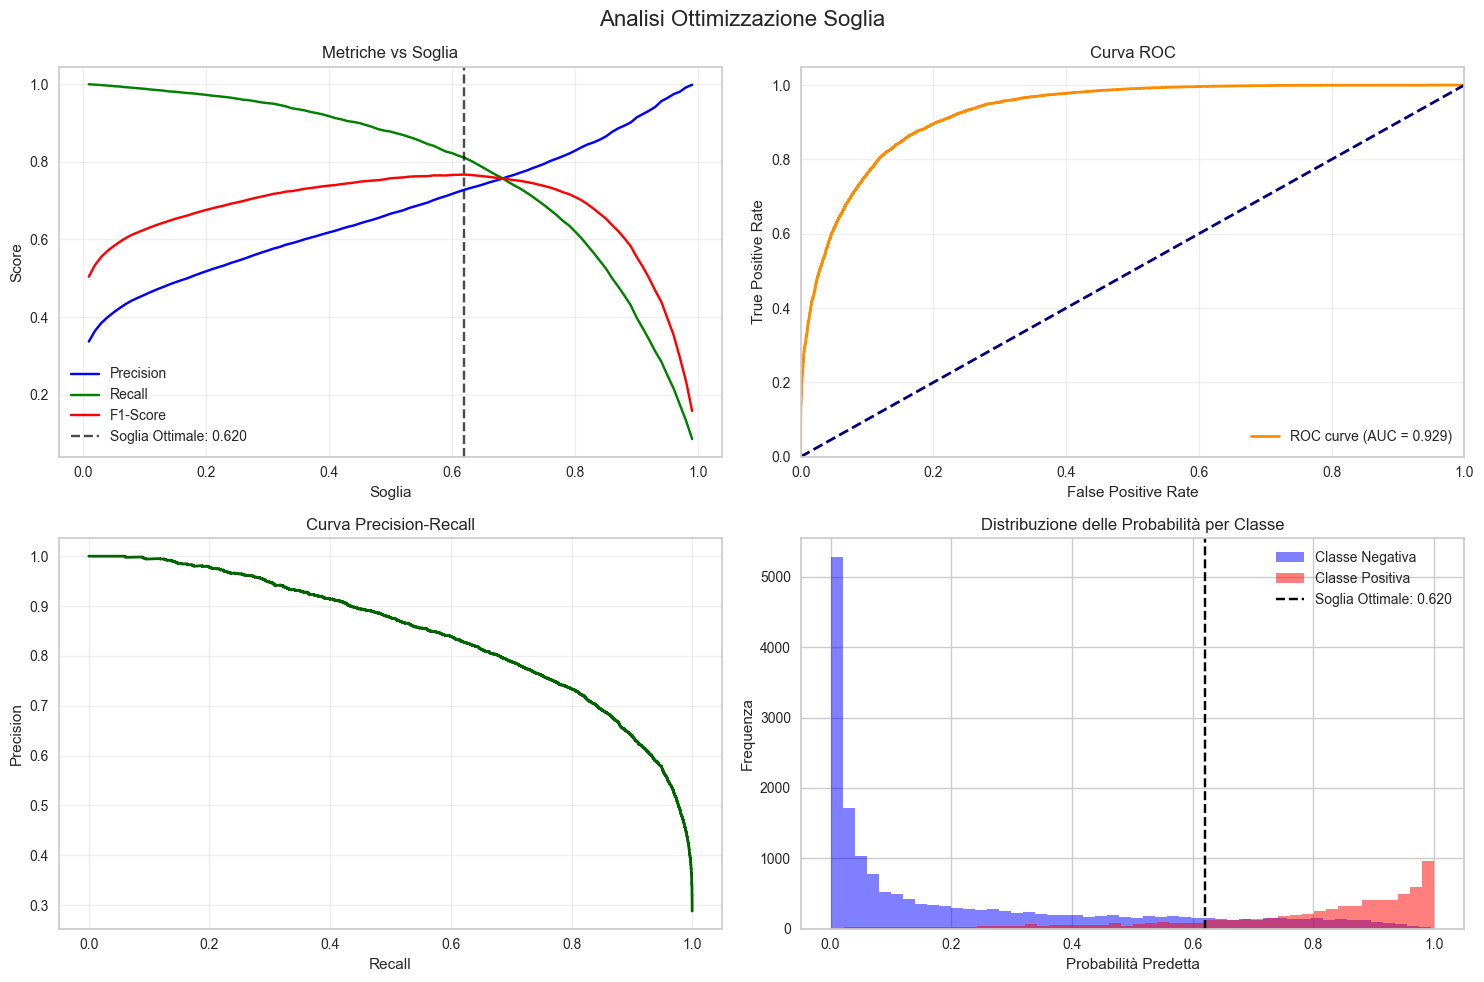


Metriche Business:
  true_positives: 5839
  true_negatives: 15614
  false_positives: 2183
  false_negatives: 1364
  sensitivity: 0.8106344578647786
  specificity: 0.8773388773388774
  positive_predictive_value: 0.7278733482921964
  negative_predictive_value: 0.9196607374249028
  total_cost: 90030
  average_cost: 3.6012


In [33]:

# Ottimizza la soglia
results = optimizer.optimize_threshold(X_val, y_val, metric='f1')

# Visualizza i risultati
optimizer.plot_threshold_analysis()
# optimizer.plot_confusion_matrix()

# Calcola metriche business (esempio con matrice dei costi)
cost_matrix = {'TP': 0, 'TN': 0, 'FP': 10, 'FN': 50}
business_metrics = optimizer.get_business_metrics(cost_matrix=cost_matrix)
print("\nMetriche Business:")
for k, v in business_metrics.items():
    print(f"  {k}: {v}")